# Performance metrics

In this notebook we return to the **supervised learning** algorithms we trained in the last notebook, but dive deeper into how to evaluate them. As we saw, **classification** and **regression** each have their own performance metrics. Classification itself can be sub-divided into **binary** and **multi-class** classification with a set of metrics for each.

The data and code-base in this notebook is very similar to the last notebook. However the exercises have changed to reflect the topic of this chapter.

We use a bank marketing data, which has demographic and activity data about bank customers, as well as information about previous attempts to contact them for a marketing campain. The target `y` is binary and indicates whether the client signed up for a term deposit or not. Let's load the data again. You can read more about the data [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

In [16]:
import pandas as pd
import numpy as np

bank = pd.read_csv("data/bank-full.csv", sep = ";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Since numeric and categorical features are often pre-processed differently, we will create variables that store the names of each to make it easier to refer to them later.

In [17]:
num_cols = bank.select_dtypes(['integer', 'float']).columns
cat_cols = bank.select_dtypes(['object']).drop(columns = "y").columns

print("Numeric columns are {}.".format(", ".join(num_cols)))
print("Categorical columns are {}.".format(", ".join(cat_cols)))

Numeric columns are age, balance, day, duration, campaign, pdays, previous.
Categorical columns are job, marital, education, default, housing, loan, contact, month, poutcome.


As usual before we can proceed to machine learning, we need to get the data ready. And since we're doing supervised learning, we need to set aside a test data set to later be evaluate the model. So let's begin by splitting the data.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bank.drop(columns = "y"), bank["y"], 
                                                    test_size = 0.15, random_state = 42)

In [19]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [20]:
print(f"Training data has {X_train.shape[0]} rows.")
print(f"Test data has {X_test.shape[0]} rows.")

Training data has 38429 rows.
Test data has 6782 rows.


Before we begin our journey of trying out different algorithms in `sklearn` we do need to encode our categorical features.

In [21]:
from sklearn.preprocessing import OneHotEncoder

onehoter = OneHotEncoder(sparse = False, drop = "first")
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

Some algorithms we're going to use (such as decision tree) won't require that we normalize our numeric features, but most will. Not doing so won't break the algorithm, but just as we saw in the case of k-means, it will skew the results. So let's Z-normalize our numeric features now.

In [22]:
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[num_cols]), columns = num_cols)
X_train_norm.head()

,age,balance,day,duration,campaign,pdays,previous
0,1.135454,-0.441514,1.342893,1.905285,-0.565758,-0.410605,-0.246723
1,0.193989,-0.393007,1.463034,0.127461,1.355238,-0.410605,-0.246723
2,-1.312355,-0.500045,1.583175,-0.685592,0.394740,-0.410605,-0.246723
3,-0.088451,-0.382982,-0.459220,-0.654471,1.035072,-0.410605,-0.246723
4,0.005696,-0.441514,-0.819643,-0.747835,0.074574,-0.410605,-0.246723


We now join our numeric features and our one-hot-encoded categorical features into one data set that we pass to the decision tree classifier.

In [23]:
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot

print("Featurized training data has {} rows and {} columns.".format(*X_train_featurized.shape))
print("Featurized test data has {} rows and {} columns.".format(*X_test_featurized.shape))

Featurized training data has 38429 rows and 42 columns.
Featurized test data has 6782 rows and 42 columns.


## Decision tree classifier

With our data ready, we can now train a decision tree classifier. There is a lot of detail that we leave for another time, but the common pattern to all the supervised learning algorithm is what we want to call attention to here: 

1. We create an **instance** of the algorithm, along with any settings we want to use. Here we instantiate a `DecisionTreeClassifier` and specify `max_depth = 10`.
1. We train the algorithm on the training data by calling the `fit` method.
1. Once the model is trained, we obtain prediction by calling the `predict` method.

In [24]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth = 5)
dtree.fit(X_train_featurized, y_train)

y_hat_train = dtree.predict(X_train_featurized)
y_hat_test = dtree.predict(X_test_featurized)

If we wish to evaluate the model, we only need to predict for the test data, but in our case we predict both for the training and test data so we can show the effect of overfitting or underfitting.

In [25]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 91%.
Accuracy on the test data: 90%.


### Exercise

- Find the counts of positive and negative classes for the target variable.
- Based on the counts, would you recommend looking using **accuracy** to measure the model's performance?
- Check out what other performance metrics are available in `sklearn.metrics` that could be relevant to evaluating this model. Choose one and report the value.

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

#bank.columns
bank['y'].value_counts()

# I'd recommend using something besides accuracy alone... only 5k of 45k customers opened an account (or whatever Y means...)

# I'd show the confusion matrix....
print(confusion_matrix(y_test, y_hat_test))
print('Accuracy is: ' + f'{accuracy_score(y_test, y_hat_test) * 100:.2f}' + '%')


[[5817  153]
 [ 535  277]]
Accuracy is: 89.86%


### End of exercise

## k-nearest neighbor classifier

A model trained using the k-nearest neighbor algorithm on the other hand is very different. It doesn't have a tree structure. Instead it labels a new data point by finding the $k$ points nearest to it and looking up what their labels are, and letting the new data's label be the same as whatever label the majority of its neighbors have. Optionally, we can let closer neighbors influence the vote more than more distant neighbors.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knnb = KNeighborsClassifier()
knnb.fit(X_train_featurized, y_train)

y_hat_train = knnb.predict(X_train_featurized)
y_hat_test = knnb.predict(X_test_featurized)

If we wish to evaluate the model, we only need to predict for the test data, but in our case we predict both for the training and test data so we can show the effect of overfitting or underfitting.

In [51]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 92%.
Accuracy on the test data: 90%.


### Exercise

- Get **precision** and **recall** for the model we trained above. Note that by default, the corresponding functions in `sklearn.metrics` expect the positive label to be the integer 1. For us, the positive label is the string `yes`, so we need to use `pos_label = 'yes'`.
- Instead of calling the `predict` method to get predictions, call the `predict_proba` method to get the probability $P(Y_i = 1)$ for each row.
- Change your the threshold from 0.50 (default) to 0.75 and based on this new threshold obtain hard predictions from the soft predictions we got in the last step.
- Obtain **precision** and **recall** once more (now that we changed the threshold).
- How did increasing the threshold change precision and recall.

In [60]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Precision score: ' + str(precision_score(y_test, y_hat_test, pos_label = 'yes')))
print('Recall score: ' + str(recall_score(y_test, y_hat_test, pos_label = 'yes')))

Precision score: 0.6421267893660532
Recall score: 0.3866995073891626


In [ ]:
# Change your the threshold from 0.50 (default) to 0.75 and based on this new threshold obtain hard predictions from the soft predictions we got in the last step
y_hat_test = knnb.predict_proba(X_test_featurized)

In [69]:
thresh = []
# meh... this came from another student.
for i in y_hat_test:
    if i[1] >= .75:
        thresh.append('yes')
    else:
        thresh.append('no')
        
        
thresh = pd.DataFrame(thresh)
thresh[0].value_counts()

        

no     6568
yes     214
Name: 0, dtype: int64

### End of exercise

## Logistic regression classifier

The logistic regression algorithm is another popular classifier. Careful here: even though it has the word **regression** in it, logistic regression is a **classification** algorithm, not a **regression** algorithm. A model trained using logistic regression predicts new classes using an **equation**. This makes logistic regression very efficient. In fact, once you have your trained model, you can pull out the equation's **coefficients** and implement it even in SQL: in just one query, although if we have a lot of features it could be nasty query!

In [70]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter = 5000)
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

Let's look at precision and recall on the training and test data.

In [71]:
from sklearn.metrics import precision_score, recall_score
precision_train = precision_score(y_train, y_hat_train, pos_label = 'yes') * 100
precision_test = precision_score(y_test, y_hat_test, pos_label = 'yes') * 100

recall_train = recall_score(y_train, y_hat_train, pos_label = 'yes') * 100
recall_test = recall_score(y_test, y_hat_test, pos_label = 'yes') * 100

print("Precision = {:.0f}% and recall = {:.0f}% on the training data.".format(precision_train, recall_train))
print("Precision = {:.0f}% and recall = {:.0f}% on the test data.".format(precision_test, recall_test))

Precision = 65% and recall = 34% on the training data.
Precision = 66% and recall = 36% on the test data.


## SVM classifier

It looks like so far logistic regression performs better than the other two models right off the bat. So it might be time to compare its performance against one of the more advanced algorithms. Let's train an SVM model. SVM stands for support vector machines and before neural networks and deep learning started making a comeback in the last few years, SVMs were considered state of the art. As you will notice from running the next line, SVMs are also very compute-heavy.

Note that by default, SVMs are **hard classifiers**, but by specifying `probability = True` we can get it to return soft predictions. Unfortunately, this comes at an added computational cost. But we need the soft predictions for later so we can plot an ROC plot.

In [72]:
from sklearn.svm import SVC

# probability = True outputs the soft predictions as well as hard predictions...
svmc = SVC(probability = True)
svmc.fit(X_train_featurized, y_train)

y_hat_train = svmc.predict(X_train_featurized)
y_hat_test = svmc.predict(X_test_featurized)

### Exercise

Obtain precision and recall for the SVM classifier we trained above and compare them to the ones we got from training the logistic regression. What are your conclusion?

In [74]:
print(precision_score(y_train, y_hat_train, pos_label = 'yes'))
print(recall_score(y_train, y_hat_train, pos_label = 'yes'))

0.7530864197530864
0.40875586330131786


### End of exercise

## Comparing classifiers using the ROC curve and AUC

So we trained so far four binary classification models. Having to look at precision and recall to determine which is best might be a little tedious, especially since in some cases there are trade-offs involved. Not to mention that the precision and recall metrics, as we saw in an earlier exercise, depend on a threshold. By default the threshold is set to 0.50, but we can change that and if we do we get new values for precision and recall, which means we have to go back to comparing our models again.

This is when the ROC plot can be helpful. Unlike precision and recall, ROC is not a single metric but a graph. The ROC curve illustrates the trade-off that happens as we change our threshold from zero to 1. The closer the ROC curve comes to the top-left corner of the plot (the $(0, 1) point$, the better the classifier. If we have two classifiers $A$ and $B$, and the ROC curve of $A$ is higher than that of $B$ **at every point**, then this classifier $A$ outperforms $B$ **regardless of what threshold we choose**.

In [75]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(models, model_names):
    plt.figure(0, figsize = [8, 7]).clf()
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    
    for ii, model in enumerate(models):
        y_prob_test = model.predict_proba(X_test_featurized)[:, 1]
        fpr, tpr, threshold = roc_curve(y_test, y_prob_test, pos_label = "yes")
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label = "{} AUC = {:0.2f}".format(model_names[ii], roc_auc))

    plt.legend(loc = 'lower right');

An ROC curve for a single classifer is not very useful, but it's when we want to compare multiple classifiers that the ROC curve can save us a lot of time. Since creating an ROC curve can be tedious, the above cell has a function that does the hard work. When we call the function, all we need to do is give it the models we trained, in a list, and corresponding labels for each. In addition to plotting the ROC curve, the plot will also show the AUC (area under the ROC curve). The closer the AUC is to 1, the better the model.

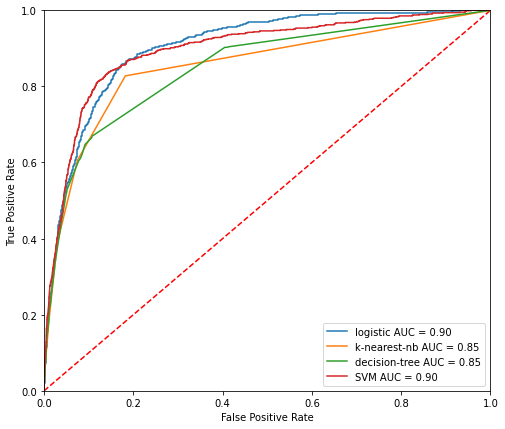

In [77]:
plot_roc([logit, knnb, dtree, svmc], ['logistic', 'k-nearest-nb', 'decision-tree', 'SVM'])

## Multi-class classification

We saw quite a few examples of training binary classification models. Now we're going to see examples of **multi-class classification**, namely when the number of classes is more than 2. As it turns out, multi-class classification isn't really that special. For example, one approach would be to build many classifiers, each one of each is going to distinguish one of the classes from the rest of them. This is referred to as **one-vs-all** or **one-vs-rest**. To get a prediction, we let each model predict with **soft predictions** and we predict the class to be whichever class obtained the highest probability.

However, this can be very inefficient when the number of classes is high, and in some use-cases such as image classification the number of classes can be in the hundreds of thousands! As we will see in future lectures, neural networks can train multi-class classifier using a single model, which is a far superior approach than one-vs-rest.

We train our multi-class classifier to predict the `job` column in the data. But because there are too many classes, we first reduce the number of classes by combining some of them. To do that, we use a remapping dictionary and pass it to the `replace` method of the `DataFrame`. We then change the target to be this new variable and drop the one-hot-encoded features related to `job` from the training and test data (otherwise we would be using `job` to predict `job` and we don't need ML to do that!).

In [79]:
remap = {'entrepreneur': 'white-collar', 'housemaid': 'blue-collar', 'admin.': 'white-collar',
         'management': 'white-collar', 'self-employed': 'self-emp', 'services': 'self-emp',
         'student': 'unemployed', 'technician': 'blue-collar', 'unknown': 'self-emp'}

y_train = X_train['job'].replace(remap)
edu_onehot_cols = X_train_featurized.filter(like = 'job').columns
print(edu_onehot_cols)
X_train_featurized = X_train_featurized.drop(columns = edu_onehot_cols)

y_test = X_test['job'].replace(remap)
X_test_featurized = X_test_featurized.drop(columns = edu_onehot_cols)

y_train.value_counts(normalize = True)

Index([], dtype='object')


blue-collar     0.411902
white-collar    0.355044
self-emp        0.134196
retired         0.050170
unemployed      0.048687
Name: job, dtype: float64

## Multi-class logistic regression

In many cases, we can run exact same code with run to train the binary classifier, and train a multi-class classifier instead. **Logistic regressoion** is a great example to try our multi-class classification on. The reason is that logistic regression is very efficient and is able to train a true multi-class classifier, and not one-vs-rest.

In [80]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter = 5000)
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

Multi-class classification adds its own set of complications when it comes to model evaluation. But let's begin with the easy part: **accuracy is still accuracy**. In other words, whether we predict two classes or many, accuracy is still the precentage of correct predictions.

In [81]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

Accuracy on the training data: 58%.
Accuracy on the test data: 58%.


But just as in the binary case, if the data has class imbalance, accuracy may paint too rosy a picture. One solution here is to use a **weighted accuracy** where the weights are chosen to give more importance to the classes we wish to emphasize. For example, in the next cell, we assgin `retired` and `unemployed` to have 10 times more weight than the remaining categories. We then measure weighted accuracy using the `sample_weight` argument.

In [82]:
is_retired_or_self = y_test.isin(['retired', 'unemployed'])
y_test_wt = is_retired_or_self * 100 + ~is_retired_or_self * 1
acc_test_wt = accuracy_score(y_test, y_hat_test, sample_weight = y_test_wt) * 100

print("Weighted cccuracy on the test data: {:.0f}%.".format(acc_test_wt))

Weighted cccuracy on the test data: 31%.


There are two things to note here:
- A weighted accuracy measure as computed above does not really have too much value in terms of explainability. They mostly serve us to have a measure to tune our models with. In other words, we can use something like the weighted accuracy as defined above to evaluate a few different models and see which one has the best performance. But the exact value of the weighted accuracy isn't something particularly noteworthy since our choice of weights wasn't something we put a lot of thought into.
- We can use weights at the time we **evaluate** a model, like we did in the above example, but we can also use weights at the time we **train** a model. Many algorithms such as `LogisticRegression` have an argument usally named `class_weight` which allows you to assign higher weights to certain classes so you can over-emphasize them **during training**. This way the model can focus on improving its predictions for those classes at the expense of the other classes.

What about measures like **precision** and **recall**? They still apply in a multi-class classification setting, but now we need to calculate precision and recall **for each class** and then average them out. To calculate precison and recall for each class, we use a **one-vs-rest** approach. To average out the values for each class, we can use a simple average (called a **macro average** here) which gives each class equal weights, or we can weigh classes by their sample size (called **support** in the results below) and caluclate a **weighted average**.

Of course we don't need to do any of that manually (phew!): we can use the `classification_report` function for that.

In [83]:
from sklearn.metrics import classification_report
cl_report_train = classification_report(y_train, y_hat_train, zero_division = 0)
cl_report_test = classification_report(y_test, y_hat_test, zero_division = 0)

print("For training data:\n")
print(cl_report_train)
print("=====================================================\n")
print("For test data:\n")
print(cl_report_test)

For training data:

              precision    recall  f1-score   support

 blue-collar       0.53      0.85      0.66     15829
     retired       0.65      0.47      0.55      1928
    self-emp       0.00      0.00      0.00      5157
  unemployed       0.56      0.11      0.18      1871
white-collar       0.68      0.57      0.62     13644

    accuracy                           0.58     38429
   macro avg       0.48      0.40      0.40     38429
weighted avg       0.52      0.58      0.53     38429


For test data:

              precision    recall  f1-score   support

 blue-collar       0.53      0.84      0.65      2740
     retired       0.67      0.49      0.57       336
    self-emp       0.00      0.00      0.00       864
  unemployed       0.56      0.10      0.17       370
white-collar       0.68      0.58      0.62      2472

    accuracy                           0.58      6782
   macro avg       0.49      0.40      0.40      6782
weighted avg       0.52      0.58      0

One last word of caution about multi-class classification. We saw in the above example that `LogisticRegression` can easily and rather efficiently accomodate multi-class classification as well. However, not all algorithms are as generous! For example, the `SVC` algorithm we used in our binary classification example can also be used for multi-class classification, but at a great cost: as [explained here](https://scikit-learn.org/stable/modules/svm.html#multi-class-classification) `SVC` uses **one-vs-one** for multi-class classification. In other words, it builds a separate classifier to predict one class vs another class. If we have $m$ classes, we have $m \choose 2$ = $\frac{m!}{(m-2)!2!}$ (the left-hand-side reads **$m$ choose 2**) classifiers to build, which for even small values of $m$ can quickly get out of control. So it's important to read the documentation of each classifier to be aware of these limits.

## Linear regression regressor

So far we've only seen classification algorithms. So it's time to change course and take a look at regression algorithms. For that we need to find a numeric target. We can use the `duration` column in the data as our target.

In [84]:
y_train = X_train_featurized['duration']
X_train_featurized = X_train_featurized.drop(columns = 'duration')

y_test = X_test_featurized['duration']
X_test_featurized = X_test_featurized.drop(columns = 'duration')

Other than changing the target from categorical to numeric, we don't have to do things very differently from before. The training and predicting part of the code remain very similar. 

In [85]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_featurized, y_train)

y_hat_train = linreg.predict(X_train_featurized)
y_hat_test = linreg.predict(X_test_featurized)

We've almost reached the end of the notebook and are just starting to talk about regression. This is because regression algorithms are more straight-forward. None of the topics we covered when we talked about classifications are really relevant in regression. Instead, we have a short list of metrics that can be used to tell us how close the prediction comes to the actual value (**root mean squared error** or **mean absolute error**) or by how much we were able to reduce our **uncertainty** (variability) about the target by modeling it using the **featuers** ($R^2$ and **adjusted $R^2$).

In [87]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, y_hat_train) ** 0.5
rmse_test = mean_squared_error(y_test, y_hat_test) ** 0.5

print("RMSE on the training data: {:5.5f}.".format(rmse_train))
print("RMSE on the test data: {:5.5f}.".format(rmse_test))

RMSE on the training data: 0.99200.
RMSE on the test data: 1.00523.


### Exercise

- Find the MAE (mean absolute error) of the model trained above. How does it compare to the RMSE?
- Find the $R^2$ (coefficient of determination) of the model trained above. How would you interpret this number?
- Find the correlation between the predicted and actual values.
- Show the distribution of the errors using `displot` in the `seaborn` package. What does the distribution suggest about the errors?

In [92]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(y_train, y_hat_train))
# MAE is lower...

from sklearn.metrics import r2_score
print(r2_score(y_train, y_hat_train))
# have no idea how to interpret this number...

np.corrcoef(y_train, y_hat_train)


0.6519520133282259
0.0159404269044624


array([[1.       , 0.1262554],
       [0.1262554, 1.       ]])

### End of exercise

Of course there is always more we can be looking at if we want to get in the weeds. And model evaluation at the end of the day is similar to EDA (exploratory data analysis) in that you have a standard set of checks, but then you can get creative depending on what you're trying to answer. As an example, let's say we are wondering how our confidence about the prediction for `duration` depends on `marital`. To answer this we need to quantify what we mean by "confidence". That's simple: if our prediction is good then error should be low. So our confidence about the prediction can be measured using the standard deviation of the error. In other words, we can compute the standard deviation of the error grouped by `marital` to answer our question:

In [ ]:
X_test['error'] = y_test - y_hat_test # compute the error
X_test['error'].groupby(X_test['marital']).std()

The above example shows the importance of having some ida **ahead-of-time** of what metrics should be used to evaluate the model. Whether it's one or a few standard metrics or some pre-defined custom metric, clarifying it ahead of time can save us some time and **prevent** us from having to go fishing for the best performance metric **after training**. In fact, doing so can be dangerous and result in over-fitting. In future classes, we learn that if we need to do this properly, in addition to the training and test set, we should also be using a **validation set**.